# Darwin's bibliography <a class="tocSkip">
<p><img src="https://assets.datacamp.com/production/project_607/img/CharlesDarwin.jpg" alt="Charles Darwin" width="300px"></p>
<p>Charles Darwin is one of the few universal figures of science. His most renowned work is without a doubt his "<em>On the Origin of Species</em>" published in 1859 which introduced the concept of natural selection. But Darwin wrote many other books on a wide range of topics, including geology, plants or his personal life. In this notebook, we will automatically detect how closely related his books are to each other.</p>
<p>To this purpose, we will develop the bases of <strong>a content-based book recommendation system</strong>, which will determine which books are close to each other based on how similar the discussed topics are. The methods we will use are commonly used in text- or documents-heavy industries such as legal, tech or customer support to perform some common task such as text classification or handling search engine queries.</p>
<p>Let's take a look at the books we'll use in our recommendation system.</p>

# Imports

## Dependencies

In [8]:
import glob
import re, os

from tqdm import tqdm_notebook

import pickle
import pandas as pd

from nltk.stem import PorterStemmer
from gensim import corpora

from gensim.models import TfidfModel
from gensim import similarities

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.cluster import hierarchy

In [7]:
ps = PorterStemmer()

## Data

In [2]:
folder = "datasets/"

files = glob.glob(folder + '*.txt')
files.sort()

In [3]:
txts = []
titles = []

for n in files:
    f = open(n, encoding='utf-8-sig')
    # Remove all non-alpha-numeric characters
    txts.append(re.sub('[\W_]+', ' ', f.read()))
    titles.append(os.path.basename(n).replace(".txt", ""))

# ['{} - {:,}'.format(title, len(txt)) for title, txt in zip(titles, txts)]

pd.DataFrame(data = [
    (title, len(txt)) for title, txt in zip(titles, txts)
], columns=['Title', '#characters']).sort_values('#characters', ascending=False)

,Title,#characters
2,DescentofMan,1776539
13,MonographCirripediaVol2,1660866
19,VoyageBeagle,1149574
16,PowerMovementPlants,1093567
10,LifeandLettersVol1,1047518
17,VariationPlantsAnimalsDomestication,1043499
11,LifeandLettersVol2,1010643
15,OriginofSpecies,916267
4,EffectsCrossSelfFertilization,913713
9,InsectivorousPlants,901406


In [4]:
# for i in range(len(titles)):
#     if titles[i] == 'OriginofSpecies':
#         ori = i

book_index = titles.index('OriginofSpecies')
book_index

15

## Tokenize

In [19]:
%%time

# stop words
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())

txts_lower_case = [txt.lower() for txt in txts]
txts_split = [txt.split() for txt in txts_lower_case]
texts = [[word for word in txt if word not in stoplist] for txt in txts_split]

print(texts[book_index][:20])

['on', 'origin', 'species', 'but', 'with', 'regard', 'material', 'world', 'can', 'least', 'go', 'so', 'far', 'this', 'can', 'perceive', 'events', 'are', 'brought', 'about']
CPU times: user 559 ms, sys: 71.8 ms, total: 631 ms
Wall time: 639 ms


## Stemming
<p>As we are analysing 20 full books, the stemming algorithm can take several minutes to run and, in order to make the process faster, we will directly load the final results from a pickle file and review the method used to generate it.</p>

In [21]:
# # Load the stemmed tokens list from the pregenerated pickle file
# texts_stem = pickle.load( open( 'datasets/texts_stem.p', 'rb' ) )

In [22]:
%%time

# texts_stem = [[ps.stem(word) for word in text] for text in texts]

texts_stem = []
for i in tqdm_notebook(range(len(texts))):
    book_stemmed = []
    
    for word in texts[i]:
        book_stemmed.append( ps.stem(word) )
    
    texts_stem.append(book_stemmed)

print(texts_stem[book_index][:20])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



['on', 'origin', 'speci', 'but', 'with', 'regard', 'materi', 'world', 'can', 'least', 'go', 'so', 'far', 'thi', 'can', 'perceiv', 'event', 'are', 'brought', 'about']
CPU times: user 55.4 s, sys: 28.9 ms, total: 55.4 s
Wall time: 55.6 s


# Modelling

## Building a bag-of-words model
<p>Now that we have transformed the texts into stemmed tokens, we need to build models that will be useable by downstream algorithms.</p>
<p>First, we need to will create a universe of all words contained in our corpus of Charles Darwin's books, which we call <em>a dictionary</em>. Then, using the stemmed tokens and the dictionary, we will create <strong>bag-of-words models</strong> (BoW) of each of our texts. The BoW models will represent our books as a list of all uniques tokens they contain associated with their respective number of occurrences. </p>
<p>To better understand the structure of such a model, we will print the five first elements of one of the "<em>On the Origin of Species</em>" BoW model.</p>

In [12]:
dictionary = corpora.Dictionary(texts_stem)

# Create a bag-of-words model for each book, using the previously generated dictionary
bows = [dictionary.doc2bow(txt) for txt in texts_stem]

print(bows[book_index][:5])

[(0, 11), (5, 51), (6, 1), (8, 2), (21, 1)]


## The most common words of a given book
<p>The results returned by the bag-of-words model is certainly easy to use for a computer but hard to interpret for a human. It is not straightforward to understand which stemmed tokens are present in a given book from Charles Darwin, and how many occurrences we can find.</p>
<p>In order to better understand how the model has been generated and visualize its content, we will transform it into a DataFrame and display the 10 most common stems for the book "<em>On the Origin of Species</em>".</p>

In [13]:
# Convert the BoW model for "On the Origin of Species" into a DataFrame
df_bow_origin = pd.DataFrame(bows[book_index], columns=['index', 'occurrences'])

# Add a column containing the token corresponding to the dictionary index
df_bow_origin['token'] = df_bow_origin['index'].apply(lambda i: texts_stem[book_index][i])

df_bow_origin.sort_values('occurrences', ascending=False).head(10)

,index,occurrences,token
748,1168,2023,histori
1119,1736,1558,by
1489,2288,1543,somewhat
892,1366,1480,have
239,393,1362,intercross
1128,1747,1201,speci
125,218,1140,domest
665,1043,1137,mysteri
1774,2703,1000,perfectli
1609,2452,962,effect


## Build a tf-idf model
<p>If it wasn't for the presence of the stem "<em>speci</em>", we would have a hard time to guess this BoW model comes from the <em>On the Origin of Species</em> book. The most recurring words are, apart from few exceptions, very common and unlikely to carry any information peculiar to the given book. We need to use an additional step in order to determine which tokens are the most specific to a book.</p>
<p>To do so, we will use a <strong>tf-idf model</strong> (term frequency–inverse document frequency). This model defines the importance of each word depending on how frequent it is in this text and how infrequent it is in all the other documents. As a result, a high tf-idf score for a word will indicate that this word is specific to this text.</p>
<p>After computing those scores, we will print the 10 words most specific to the "<em>On the Origin of Species</em>" book (i.e., the 10 words with the highest tf-idf score).</p>

In [20]:
model = TfidfModel(bows)

# Print the model for "On the Origin of Species"
print(len(model[bows[book_index]]))

4405


## The results of the tf-idf model
<p>Once again, the format of those results is hard to interpret for a human. Therefore, we will transform it into a more readable version and display the 10 most specific words for the "<em>On the Origin of Species</em>" book.</p>

In [15]:
# Convert the tf-idf model for "On the Origin of Species" into a DataFrame
df_tfidf = pd.DataFrame(model[bows[book_index]], columns=['id', 'score'])

# Add the tokens corresponding to the numerical indices for better readability
df_tfidf['token'] = df_tfidf['id'].apply(lambda i: texts_stem[book_index][i])

df_tfidf.sort_values('score', ascending=False).head(10)

,id,score,token
880,2164,0.327823,variat
3103,10108,0.204162,alway
128,369,0.197968,it
2985,9395,0.167705,frequent
947,2325,0.148371,gener
285,752,0.146172,slow
504,1255,0.128433,reader
371,966,0.127694,458
3840,16046,0.124547,epidem
3536,12729,0.121348,are


## Compute distance between texts
<p>The results of the tf-idf algorithm now return stemmed tokens which are specific to each book. We can, for example, see that topics such as selection, breeding or domestication are defining "<em>On the Origin of Species</em>" (and yes, in this book, Charles Darwin talks quite a lot about pigeons too). Now that we have a model associating tokens to how specific they are to each book, we can measure how related to books are between each other.</p>
<p>To this purpose, we will use a measure of similarity called <strong>cosine similarity</strong> and we will visualize the results as a distance matrix, i.e., a matrix showing all pairwise distances between Darwin's books.</p>

In [16]:
sims = similarities.MatrixSimilarity(model[bows])

sim_df = pd.DataFrame(list(sims))
sim_df.columns = titles
sim_df.index = titles

print(sim_df)

/usr/local/lib/python3.5/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


                                     Autobiography  CoralReefs  DescentofMan  \
Autobiography                             1.000000    0.049722      0.080789   
CoralReefs                                0.049722    1.000000      0.009516   
DescentofMan                              0.080789    0.009516      1.000000   
DifferentFormsofFlowers                   0.066615    0.001980      0.072792   
EffectsCrossSelfFertilization             0.077006    0.001936      0.029997   
ExpressionofEmotionManAnimals             0.089345    0.005062      0.148642   
FormationVegetableMould                   0.041182    0.029445      0.027106   
FoundationsOriginofSpecies                0.058990    0.022066      0.135001   
GeologicalObservationsSouthAmerica        0.030679    0.060744      0.009628   
InsectivorousPlants                       0.014945    0.002284      0.009468   
LifeandLettersVol1                        0.399534    0.031211      0.060040   
LifeandLettersVol2                      

## The book most similar to "On the Origin of Species"
<p>We now have a matrix containing all the similarity measures between any pair of books from Charles Darwin! We can now use this matrix to quickly extract the information we need, i.e., the distance between one book and one or several others. </p>
<p>As a first step, we will display which books are the most similar to "<em>On the Origin of Species</em>," more specifically we will produce a bar chart showing all books ranked by how similar they are to Darwin's landmark work.</p>

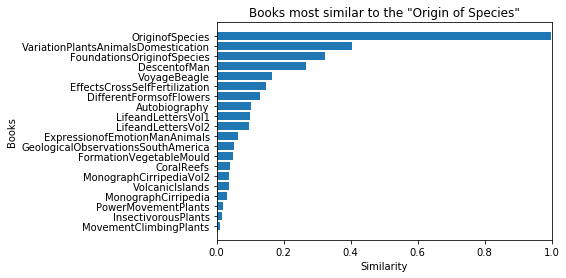

In [17]:
v = sim_df.OriginofSpecies
v_sorted = v.sort_values()
# v_sorted = v_sorted[:-1]

plt.barh(range(len(v_sorted)), v_sorted.values)

plt.xlabel('Similarity')
plt.ylabel('Books')
plt.yticks(range(len(v_sorted)), v_sorted.index)
plt.xlim((0, 1))
plt.title('Books most similar to the "Origin of Species"')

plt.show()

## Which books have similar content?
<p>This turns out to be extremely useful if we want to determine a given book's most similar work. For example, we have just seen that if you enjoyed "<em>On the Origin of Species</em>," you can read books discussing similar concepts such as "<em>The Variation of Animals and Plants under Domestication</em>" or "<em>The Descent of Man, and Selection in Relation to Sex</em>." If you are familiar with Darwin's work, these suggestions will likely seem natural to you. Indeed, <em>On the Origin of Species</em> has a whole chapter about domestication and <em>The Descent of Man, and Selection in Relation to Sex</em> applies the theory of natural selection to human evolution. Hence, the results make sense.</p>
<p>However, we now want to have a better understanding of the big picture and see how Darwin's books are generally related to each other (in terms of topics discussed). To this purpose, we will represent the whole similarity matrix as a dendrogram, which is a standard tool to display such data. <strong>This last approach will display all the information about book similarities at once.</strong> For example, we can find a book's closest relative but, also, we can visualize which groups of books have similar topics (e.g., the cluster about Charles Darwin personal life with his autobiography and letters). If you are familiar with Darwin's bibliography, the results should not surprise you too much, which indicates the method gives good results. Otherwise, next time you read one of the author's book, you will know which other books to read next in order to learn more about the topics it addressed.</p>

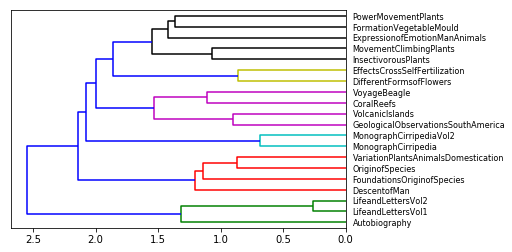

In [18]:
Z = hierarchy.linkage(sim_df, method='ward')

a = hierarchy.dendrogram(
    Z,
    leaf_font_size=8,
    labels=sim_df.index,
    orientation="left"
)

---